In [ ]:
!pip install torch torchvision

In [ ]:
!pip install captum

In [3]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [4]:
!wget http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv

--2020-07-30 19:01:16--  http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv
Resolving biostat.mc.vanderbilt.edu (biostat.mc.vanderbilt.edu)... 160.129.37.119
Connecting to biostat.mc.vanderbilt.edu (biostat.mc.vanderbilt.edu)|160.129.37.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116752 (114K) [text/csv]
Saving to: ‘titanic3.csv’

titanic3.csv        100%[===================>] 114.02K   120KB/s    in 0.9s    

2020-07-30 19:01:19 (120 KB/s) - ‘titanic3.csv’ saved [116752/116752]



In [5]:
dataset_path = "titanic3.csv"

In [6]:


# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [7]:
# Convert to categorical variables
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)

In [9]:
titanic_data.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,1,0,1,0,0,0,0,1
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,1,0,1,0,0,0,0,1
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,0,1,1,0,0,0,0,1
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,0,1,1,0,0,0,0,1
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN,0,1,0,0,1,0,0,1


In [10]:
# Fill missing values
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())

# Remove the originating columns & other information
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [11]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

In [14]:
titanic_data.shape

(1309, 12)

In [12]:
# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [15]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [17]:
!wget https://github.com/pytorch/captum/raw/master/tutorials/models/cifar_torchvision.pt

--2020-07-30 19:12:23--  https://github.com/pytorch/captum/raw/master/tutorials/models/cifar_torchvision.pt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/captum/master/tutorials/models/cifar_torchvision.pt [following]
--2020-07-30 19:12:24--  https://raw.githubusercontent.com/pytorch/captum/master/tutorials/models/cifar_torchvision.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249703 (244K) [application/octet-stream]
Saving to: ‘cifar_torchvision.pt.1’

cifar_torchvision.p 100%[===================>] 243.85K  --.-KB/s    in 0.05s   

2020-07-30 19:12:25 (4.35 MB/s) - ‘cifar_torchvision.

In [23]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('titanic_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'titanic_model_2.pt')

Epoch 1/200 => Loss: 0.75
Epoch 21/200 => Loss: 0.58
Epoch 41/200 => Loss: 0.52
Epoch 61/200 => Loss: 0.52
Epoch 81/200 => Loss: 0.50
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.49
Epoch 161/200 => Loss: 0.49
Epoch 181/200 => Loss: 0.48


In [24]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8209606986899564


In [26]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))


Test Accuracy: 0.8193384223918575


In [27]:
ig = IntegratedGradients(net)

In [28]:

test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age :  -0.563
sibsp :  -0.078
parch :  -0.012
fare :  0.068
female :  0.309
male :  -0.348
embark_C :  0.084
embark_Q :  0.007
embark_S :  -0.079
class_1 :  0.098
class_2 :  0.064
class_3 :  -0.296


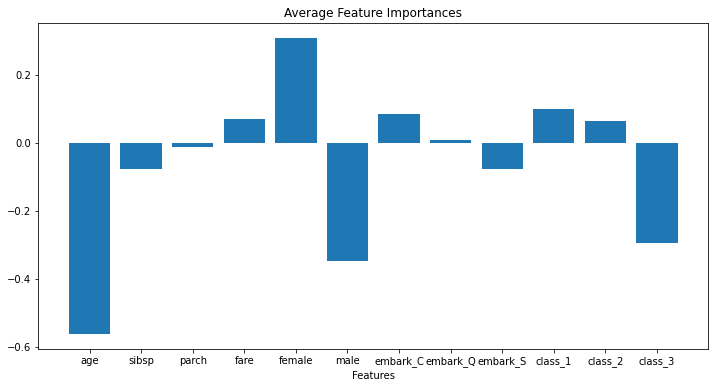

In [29]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

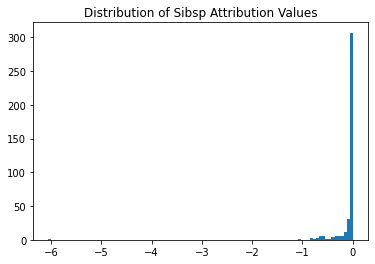

In [30]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

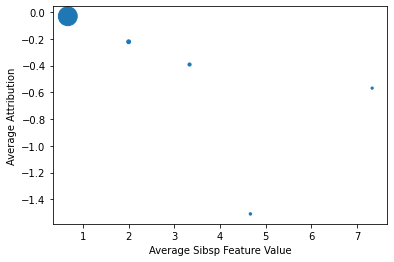

In [31]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

In [32]:
cond = LayerConductance(net, net.sigmoid1)

In [33]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  -0.006
1 :  0.002
2 :  -0.008
3 :  -0.129
4 :  -0.002
5 :  -0.005
6 :  -0.009
7 :  -0.152
8 :  -0.237
9 :  -0.157
10 :  -0.001
11 :  -0.001


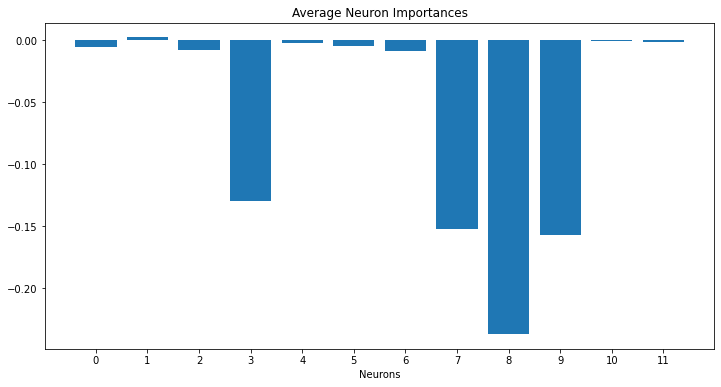

In [34]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

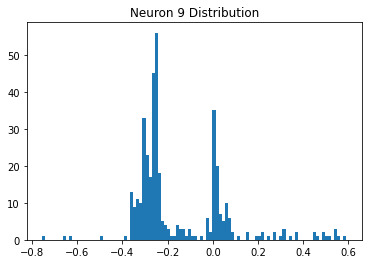

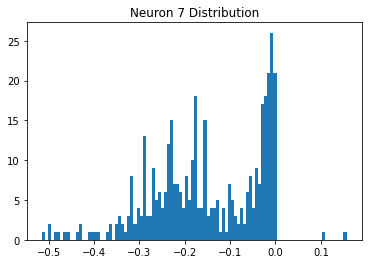

In [35]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

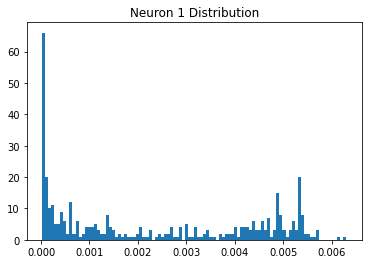

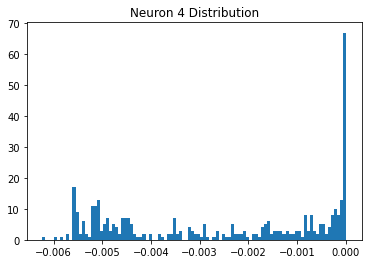

In [37]:
plt.hist(cond_vals[:,1], 100);
plt.title("Neuron 1 Distribution")
plt.figure()
plt.hist(cond_vals[:,4], 100);
plt.title("Neuron 4 Distribution");

In [38]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [39]:
neuron_cond_vals_7 = neuron_cond.attribute(test_input_tensor, neuron_index=7, target=1)

neuron_cond_vals_9 = neuron_cond.attribute(test_input_tensor, neuron_index=9, target=1)

Average Feature Importances for Neuron 7
age :  -0.251
sibsp :  -0.028
parch :  0.023
fare :  0.055
female :  0.000
male :  0.013
embark_C :  0.004
embark_Q :  -0.001
embark_S :  0.003
class_1 :  0.001
class_2 :  0.015
class_3 :  -0.028


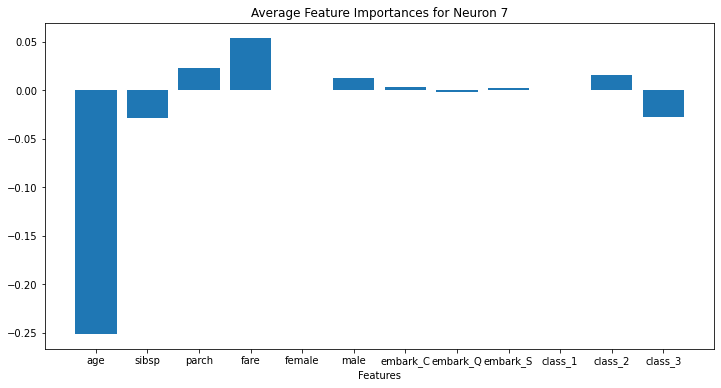

In [40]:
visualize_importances(feature_names, neuron_cond_vals_7.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 7")

Average Feature Importances for Neuron 9
age :  0.076
sibsp :  -0.012
parch :  -0.019
fare :  -0.040
female :  0.171
male :  -0.245
embark_C :  0.035
embark_Q :  0.000
embark_S :  -0.033
class_1 :  0.076
class_2 :  0.012
class_3 :  -0.171


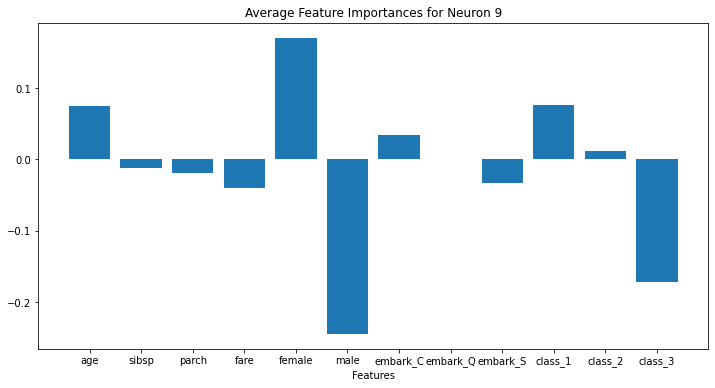

In [41]:
visualize_importances(feature_names, neuron_cond_vals_9.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 9")